In [ ]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install --upgrade psutil

In [1]:
# based on https://github.com/Sxela/stylegan3_blending/blob/main/stylegan3_blending_public.ipynb

import os
import sys
sys.path.append(os.path.join(os.path.abspath(""), "stylegan3"))
import copy
import math
import pickle
from glob import glob
import numpy as np
import cv2
import PIL
from IPython.display import display
from tqdm.notebook import trange

import torch
from torchvision.transforms.functional import to_tensor, to_pil_image


init_model = "stylegan3-t-ffhqu-256x256.pkl"
trainData = "arcaneFilteredData.zip"
finetuned_path = "model_stylegan3_finetuned"
createdDataPath = "stylegan3_data_arcane/"
createdDataPhotoPath = createdDataPath + "photo"
createdDataAnimePath = createdDataPath + "anime"

for i in [finetuned_path, createdDataPhotoPath, createdDataAnimePath]:
    os.makedirs(i, exist_ok=True)


# Download pretrained checkpoint
!wget -nc https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/{init_model}

File ‘stylegan3-t-ffhqu-256x256.pkl’ already there; not retrieving.



In [ ]:
#train stylegan
!cd stylegan3 && python train.py --outdir="../$finetuned_path" --data="../$trainData" \
    --cfg=stylegan3-t --gpus=1 --batch=32 --gamma=2 --batch-gpu=16 --snap=10 \
    --mirror=1 --freezed=10 --cbase=16384 --resume="../$init_model"


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 16384,
    "channel_max": 512,
    "magnitude_ema_beta": 0.9988915792636801
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 10
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 16384,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 2.0,
    "blur_init_sigma": 0
  },
  "data_loader_kwargs": {
    "pin_memory

In [2]:
#get recent finetuned model weight path
def getRecentPkl(path):
    pklList=glob(finetuned_path+"/**/*.pkl", recursive=True)
    pklList.sort()
    return pklList[-1]

finetuned_model=getRecentPkl(finetuned_path)

In [3]:
# load model
def get_model(path):
    with open(path, 'rb') as f:
        _G = pickle.load(f)['G_ema'].cuda()
    return _G

G_raw = get_model(init_model)
G_tuned = get_model(finetuned_model)
G_blend = copy.deepcopy(G_raw)

In [4]:
#blend model weight and create data pair

def doBlend(blendRatio): 
    # Not blending affine layers gives us colors closer to the original gen, without affecting the geometry much.
    W_new = G_raw.synthesis.state_dict().copy()
    W_tuned = G_tuned.synthesis.state_dict()
    for key in W_new:
        if "input" in key or 'affine' in key: continue
        l = blendRatio[int(key.split('_')[0][1:])]
        W_new[key] = W_tuned[key]*l + W_new[key]*(1-l)
    G_blend.synthesis.load_state_dict(W_new)
    return G_blend

def getImage(model,seed=42):
    torch.manual_seed(seed)
    z = torch.randn(1,model.z_dim).cuda()
    w = model.mapping(z, None, truncation_psi=0.5, truncation_cutoff=8)
    image = model.synthesis(w, noise_mode='const', force_fp32=True).cpu()[0]
    image = to_pil_image((image * 0.5 + 0.5).clip(0, 1))
    return image


blendRatio1 = [0,0,0,0,0,0,0,.2,.5,.7,.9,1,1,1,1]
blendRatio2 = [0,0,0,0,0,0,0,.2,.5,.7,.8,.8,.8,.8,.8]
blendRatio3 = [0,0,0,0,0,.2,.2,.2,.5,.7,.8,.8,.8,.8,1]
blendRatio4 = [0]*7+[.8]*(15-7)
G_blend=doBlend(blendRatio3)
imageNum=10000

for i in trange(imageNum):
    im1 = getImage(G_raw,seed=i)
    im3 = getImage(G_blend,seed=i)
    
    im1.save(f'{createdDataPhotoPath}/s{i}_.jpg', quality=100, subsampling=0)
    im3.save(f'{createdDataAnimePath}/s{i}_.jpg', quality=100, subsampling=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


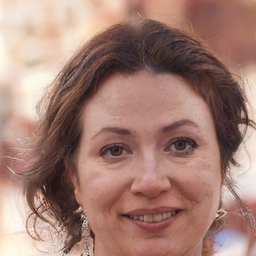

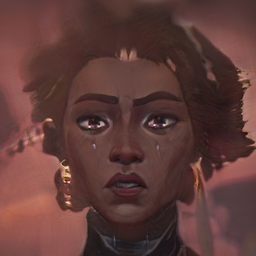

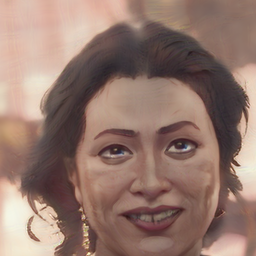

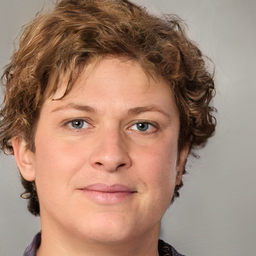

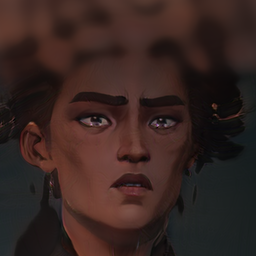

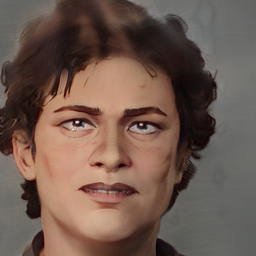

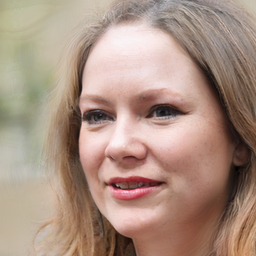

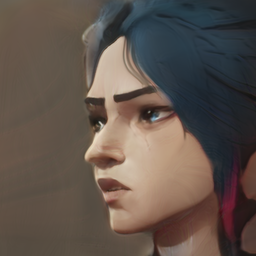

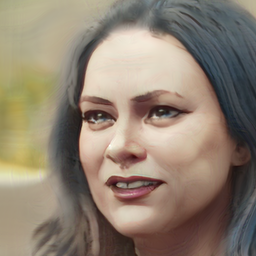

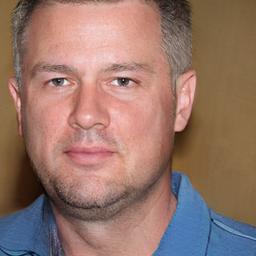

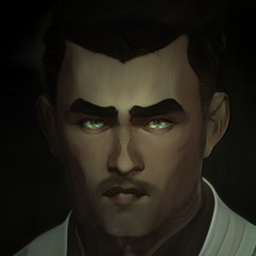

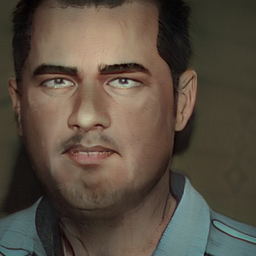

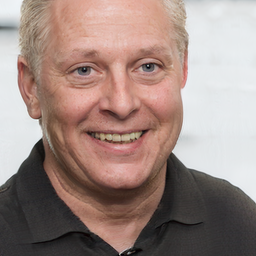

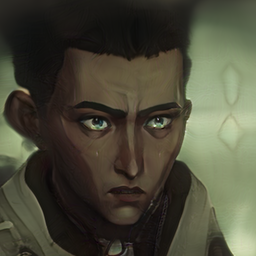

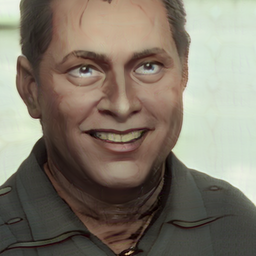

In [5]:
#display created image
for i in trange(5):
    im1 = getImage(G_raw,seed=i)
    im2 = getImage(G_tuned,seed=i)
    im3 = getImage(G_blend,seed=i)
    
    display(im1)
    display(im2)
    display(im3)